## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf', 'mean', 'grid', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [36]:
np.random.seed(42)

In [37]:
df = pd.read_csv('data.adult.csv')

In [38]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [39]:
display(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

In [40]:
df.loc[df['workclass'] == '?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
29,77,?,152900,5th-6th,3,Married-civ-spouse,?,Husband,White,Male,0,0,20,<=50K
36,17,?,89870,10th,6,Never-married,?,Own-child,White,Male,0,0,40,<=50K
38,76,?,431192,7th-8th,4,Widowed,?,Not-in-family,White,Male,0,0,2,<=50K
69,36,?,389850,HS-grad,9,Married-spouse-absent,?,Unmarried,Black,Male,0,0,50,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,64,?,196288,Assoc-acdm,12,Never-married,?,Not-in-family,White,Female,0,0,20,<=50K
16223,17,?,202521,11th,7,Never-married,?,Own-child,White,Male,0,0,40,<=50K
16239,19,?,169324,Some-college,10,Never-married,?,Own-child,White,Male,0,0,10,<=50K
16245,59,?,367984,Bachelors,13,Married-civ-spouse,?,Husband,White,Male,0,0,40,<=50K


In [41]:
df = df[df.workclass != '?']


In [42]:
df.loc[df['workclass'] == '?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"


In [43]:
df.loc[df['occupation'] == '?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
3746,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,<=50K
9716,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,<=50K
12409,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,<=50K
13867,20,Never-worked,462294,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,<=50K


In [44]:
df = df[df.occupation != '?']

In [45]:
df.loc[df['occupation'] == '?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [46]:
y = df['>50K,<=50K']

In [47]:
df['y'] = (df['>50K,<=50K'] == '<=50K').astype('int')

df['y']

0        1
1        1
2        1
3        1
4        0
        ..
16275    1
16276    0
16277    1
16278    1
16279    0
Name: y, Length: 15347, dtype: int64

In [48]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
y                  int64
dtype: object

In [49]:
num_cols = df[['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']]

num_cols

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


In [50]:
df.drop('>50K,<=50K', axis = 1, inplace = True)

In [51]:
X = df.iloc[:,:-1]

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [53]:
neigh = KNeighborsClassifier()

params = {'n_neighbors': np.arange(1, 15, 1)}
cv = GridSearchCV(neigh, params, scoring='roc_auc', cv = 5)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

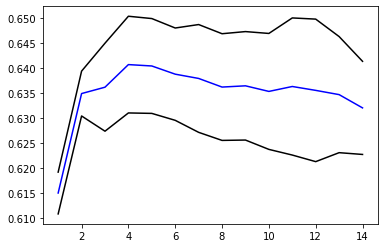

In [54]:
plt.plot(np.arange(1, 15, 1), mean, color = 'blue')
plt.plot(np.arange(1, 15, 1), mean - std, color = 'black')
plt.plot(np.arange(1, 15, 1), mean + std, color = 'black')

In [55]:
clf = DecisionTreeClassifier()

params = {'max_depth': np.arange(1, 15, 1)}
cv = GridSearchCV(clf, params, scoring='roc_auc', cv = 5)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

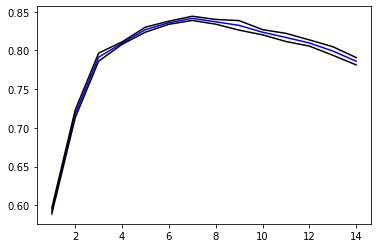

In [56]:
plt.plot(np.arange(1, 15, 1), mean, color = 'blue')
plt.plot(np.arange(1, 15, 1), mean - std, color = 'black')
plt.plot(np.arange(1, 15, 1), mean + std, color = 'black')

In [57]:
sgd = SGDClassifier()

params = {'loss': ['hinge', 'log', 'perceptron']}
cv = GridSearchCV(sgd, params, scoring='roc_auc', cv = 5)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

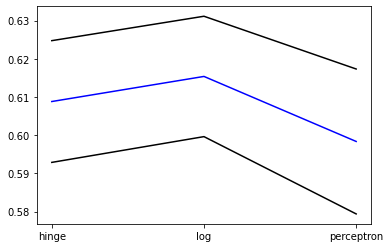

In [58]:
plt.plot(['hinge', 'log', 'perceptron'], mean, color = 'blue')
plt.plot(['hinge', 'log', 'perceptron'], mean - std, color = 'black')
plt.plot(['hinge', 'log', 'perceptron'], mean + std, color = 'black')

Вывод, у алгоритмов есть параболическая зависимость от гиперпараметра, например для дерева оптимальная глубина примерно 7. Но чем больше глубина, тем качество падает

У методы ближайших соседей оптимальное значение в районе 4-5, дальше качество падает, то есть рок-аук

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [59]:
#your code here

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

(array([2466., 2776., 2966., 3066., 1931., 1203.,  667.,  183.,   62.,
          27.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <BarContainer object of 10 artists>)

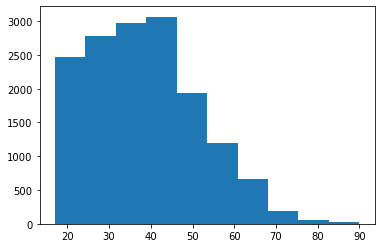

In [60]:
plt.hist(df['age'])

(array([6.681e+03, 6.863e+03, 1.528e+03, 2.150e+02, 4.400e+01, 4.000e+00,
        6.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([  19302. ,  165842.3,  312382.6,  458922.9,  605463.2,  752003.5,
         898543.8, 1045084.1, 1191624.4, 1338164.7, 1484705. ]),
 <BarContainer object of 10 artists>)

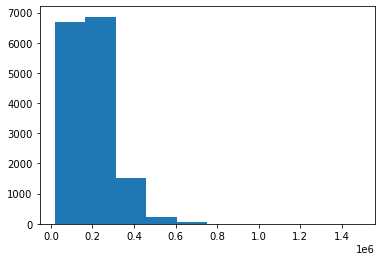

In [61]:
plt.hist(df['fnlwgt'])

(array([1.498e+04, 2.560e+02, 4.300e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.600e+01]),
 array([    0. ,  9999.9, 19999.8, 29999.7, 39999.6, 49999.5, 59999.4,
        69999.3, 79999.2, 89999.1, 99999. ]),
 <BarContainer object of 10 artists>)

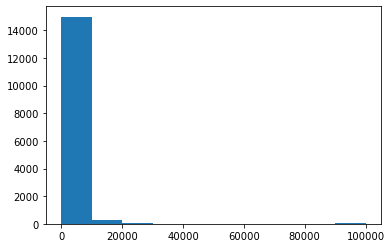

In [62]:
plt.hist(df['capital-gain'])

У данных разный масштаб, что сильно влияет на метод ближайших соседей

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
ss = StandardScaler()

num_cols = ss.fit_transform(num_cols)

In [ ]:
neigh = KNeighborsClassifier()

params = {'n_neighbors': np.arange(1, 30, 1)}
cv = GridSearchCV(neigh, params, scoring='roc_auc', cv = 5)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

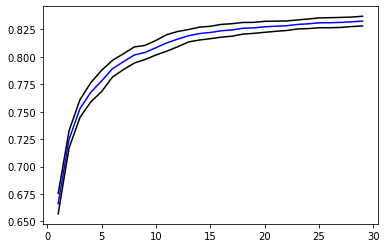

In [34]:
plt.plot(np.arange(1, 30, 1), mean, color = 'blue')
plt.plot(np.arange(1, 30, 1), mean - std, color = 'black')
plt.plot(np.arange(1, 30, 1), mean + std, color = 'black')

In [66]:
clf = DecisionTreeClassifier()

params = {'max_depth': np.arange(1, 15, 1)}
cv = GridSearchCV(clf, params, scoring='roc_auc', cv = 5)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

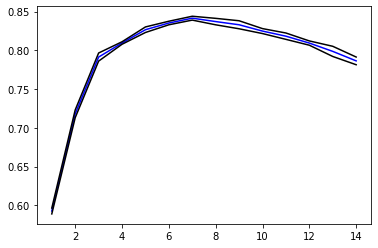

In [67]:
plt.plot(np.arange(1, 15, 1), mean, color = 'blue')
plt.plot(np.arange(1, 15, 1), mean - std, color = 'black')
plt.plot(np.arange(1, 15, 1), mean + std, color = 'black')

In [68]:
sgd = SGDClassifier()

params = {'loss': ['hinge', 'log', 'perceptron']}
cv = GridSearchCV(sgd, params, scoring='roc_auc', cv = 3)
cv.fit(num_cols, y)

mean = cv.cv_results_.get("mean_test_score")
std = cv.cv_results_.get("std_test_score")

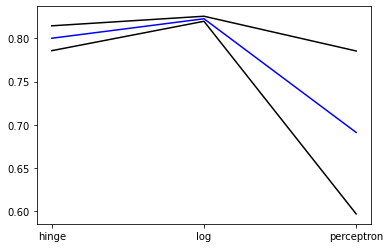

In [69]:
plt.plot(['hinge', 'log', 'perceptron'], mean, color = 'blue')
plt.plot(['hinge', 'log', 'perceptron'], mean - std, color = 'black')
plt.plot(['hinge', 'log', 'perceptron'], mean + std, color = 'black')

У методы ближайших соседей и sgd качество выросло, а у деревьев не изменилось. Тк первые 2 зависит от масштабирования

Изменилось ли качество у некоторых алгоритмов?

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [70]:
import warnings

warnings.filterwarnings('ignore')

In [71]:
neigh = KNeighborsClassifier()

params = {'n_neighbors': np.arange(1, 30, 1), 
          'metric': ['euclid', 'Manhattan']}
cv1 = GridSearchCV(neigh, params, scoring='roc_auc', cv = 3)
cv1.fit(num_cols, y)

print(cv1.best_params_)

ValueError: Metric 'euclid' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

In [72]:
clf = DecisionTreeClassifier()

params = {'max_depth': np.arange(1, 15, 1),
         'criterion': ['entropy', 'gini']}
cv2 = GridSearchCV(clf, params, scoring='roc_auc', cv = 5)
cv2.fit(num_cols, y)

print(cv2.best_params_)

{'criterion': 'entropy', 'max_depth': 8}


In [73]:
sgd = SGDClassifier()

params = {'loss': ['hinge', 'log', 'perceptron'],
         'penalty': ['l1', 'l2']}
cv3 = GridSearchCV(sgd, params, scoring='roc_auc', cv = 5)
cv3.fit(num_cols, y)

print(cv3.best_params_)

{'loss': 'log', 'penalty': 'l1'}


In [74]:
rfc = RandomForestClassifier(n_estimators = 90)

params = {'max_features': ['sqrt', 'log2'], 'criterion': ['entropy', 'gini']}
cv4 = GridSearchCV(rfc, params, scoring='roc_auc', cv = 5)
cv4.fit(num_cols, y)

print(cv4.best_params_)

{'criterion': 'entropy', 'max_features': 'log2'}


In [75]:
from sklearn.ensemble import GradientBoostingClassifier

In [76]:
gbc = GradientBoostingClassifier(n_estimators = 40)

params =  {'max_features': ['sqrt', 'log2'],'criterion': ['mse', 'mae']}
cv5 = GridSearchCV(gbc, params, scoring='roc_auc', cv = 5)
cv5.fit(num_cols, y)

print(cv5.best_params_)

{'criterion': 'mse', 'max_features': 'sqrt'}


In [77]:
print(cross_val_score(cv1.best_estimator_, num_cols, y, cv = 3, scoring='roc_auc').mean())

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [78]:
print(cross_val_score(cv2.best_estimator_, num_cols, y, cv = 3, scoring='roc_auc').mean())

0.837084149760904


In [79]:
print(cross_val_score(cv3.best_estimator_, num_cols, y, cv = 3, scoring='roc_auc').mean())

0.8214153362731681


In [80]:
print(cross_val_score(cv4.best_estimator_, num_cols, y, cv = 3, scoring='roc_auc').mean())

0.8159220221984942


In [81]:
print(cross_val_score(cv5.best_estimator_, num_cols, y, cv = 3, scoring='roc_auc').mean())

0.8526837984532234


Наилучшее качество у градиентного бустинга

Какой из алгоритмов имеет наилучшее качество? 

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Дольше всего работал Градиентный бустинг, тк он обучает последовательно. Быстрее обучается лес, а остальные еще быстрее, а дерево самое быстрое

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [82]:
X = pd.get_dummies(X, ['workclass', 'education', 'marital-status', 'occupation', 'relationship','race', 'sex'], drop_first=True)

In [83]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,514716,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16276,32,207668,13,15024,0,45,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
16277,27,104457,13,0,0,40,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
16278,59,268700,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [84]:
scaler = StandardScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])

KeyError: "None of [Index([       (-0.3429185036384002, 0.9002580213198373, -0.4507877695305961, -0.06559950639591754, -0.2187404051400785, 1.588223046140229),\n       (0.11476012538238702, 0.010682713313361904, -0.059085816241837084, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n            (-0.19035896063147115, -0.1062802622573392, 1.11602004362444, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n         (-1.2582757616799747, -0.0413823692806101, -0.059085816241837084, -0.15043861999758246, -0.2187404051400785, -0.9053787758013038),\n                (0.6487185259066388, -0.3711968859799745, 1.11602004362444, 1.9953910816041245, -0.2187404051400785, -0.07417816848745949),\n            (-1.5633948476938329, 2.423712067990726, -0.059085816241837084, -0.15043861999758246, -0.2187404051400785, -1.320979079458226),\n           (-0.5717578181487938, -0.7591541945894847, 0.7243180903356811, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n          (-1.0294364471695812, -0.7434048363924647, -0.4507877695305961, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n              (1.106397154927426, -0.20457733181675725, 1.11602004362444, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n          (-1.4871150761903684, -0.5413445221765744, -0.4507877695305961, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n       ...\n          (2.403153270486323, -0.7882067741070462, -0.059085816241837084, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n           (-0.5717578181487938, -0.5202136628513013, 0.7243180903356811, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n       (-0.4954780466453293, 0.015330373378671295, -0.059085816241837084, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n            (0.6487185259066388, -0.0002966779745248556, -1.2341916761081142, -0.15043861999758246, 3.444716113593225, 1.4219829246774602),\n                (0.4198792113962452, 0.6917813019125685, -0.4507877695305961, -0.15043861999758246, 3.491588621240318, 0.3414221351694626),\n               (-1.0294364471695812, 3.062953491345881, 1.11602004362444, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n                 (-0.4954780466453293, 0.17417873884969104, 1.11602004362444, 1.9953910816041245, -0.2187404051400785, 0.3414221351694626),\n              (-0.876876904162652, -0.7968529271435226, 1.11602004362444, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n            (1.5640757839482133, 0.7483811459467816, -0.4507877695305961, -0.15043861999758246, -0.2187404051400785, -0.07417816848745949),\n                (-0.41919827514186475, -1.2237414449640658, 1.11602004362444, -0.15043861999758246, 4.473444307742577, 0.3414221351694626)],\n      dtype='object', length=15347)] are in the [columns]"

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [85]:
neigh = KNeighborsClassifier()

params = {'n_neighbors': np.arange(1, 30, 1), 
          'metric': ['euclid', 'Manhattan']}
cv1 = GridSearchCV(neigh, params, scoring='roc_auc', cv = 3)
cv1.fit(X, y)

print(cv1.best_params_)

ValueError: Metric 'euclid' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

In [86]:
clf = DecisionTreeClassifier()

params = {'max_depth': np.arange(1, 15, 1),
         'criterion': ['entropy', 'gini']}
cv2 = GridSearchCV(clf, params, scoring='roc_auc', cv = 5)
cv2.fit(X, y)

print(cv2.best_params_)

{'criterion': 'entropy', 'max_depth': 7}


In [1]:
sgd = SGDClassifier()

params = {'loss': ['hinge', 'log', 'perceptron'],
         'penalty': 'l2'}
cv3 = GridSearchCV(sgd, params, scoring='roc_auc', cv = 3)
cv3.fit(X, y)

print(cv3.best_params_)

NameError: name 'SGDClassifier' is not defined

In [88]:
rfc = RandomForestClassifier(n_estimators = 90)

params = {'max_features': ['sqrt', 'log2'], 'criterion': ['entropy', 'gini']}
cv4 = GridSearchCV(rfc, params, scoring='roc_auc', cv = 5)
cv4.fit(X, y)

print(cv4.best_params_)

{'criterion': 'entropy', 'max_features': 'sqrt'}


In [89]:
gbc = GradientBoostingClassifier(n_estimators = 40)

params =  {'max_features': ['sqrt', 'log2'],'criterion': ['mse', 'mae']}
cv5 = GridSearchCV(gbc, params, scoring='roc_auc', cv = 5)
cv5.fit(X, y)

print(cv5.best_params_)

{'criterion': 'mse', 'max_features': 'sqrt'}


In [90]:
print(cross_val_score(cv1.best_estimator_, X, y, cv = 3, scoring='roc_auc').mean())

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [91]:
print(cross_val_score(cv2.best_estimator_, X, y, cv = 3, scoring='roc_auc').mean())

0.8915953067839729


In [92]:
print(cross_val_score(cv3.best_estimator_, X, y, cv = 3, scoring='roc_auc').mean())

0.6481933772391406


In [93]:
print(cross_val_score(cv4.best_estimator_, X, y, cv = 3, scoring='roc_auc').mean())

0.8988866951083659


In [94]:
print(cross_val_score(cv5.best_estimator_, X, y, cv = 3, scoring='roc_auc').mean())

0.9054427104548898


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [ ]:
#your code here

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [95]:
from sklearn.model_selection import KFold

In [96]:
kfold = KFold(n_splits = 5)
result = []

for i in np.arange(0, 1.1, 0.1):
    s = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        cv4.best_estimator_.fit(X_train, y_train)
        cv5.best_estimator_.fit(X_train, y_train)
        predict = i * cv4.best_estimator_.predict_proba(X_test)[:,1] + (1 - i) * cv5.best_estimator_.predict_proba(X_test)[:,1]
        s.append(roc_auc_score(y_test, predict))
    result.append(np.array(s).mean())



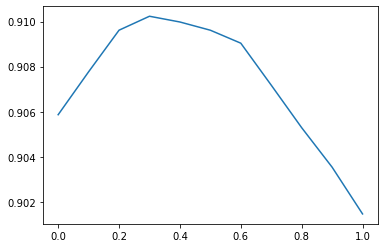

In [97]:
plt.plot(np.arange(0, 1.1, 0.1), result)

Вес леса = 0.3, вес бустинга 0.7
Значение roc_auc чуть больше для комбинации, чем для отдельных

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [ ]:
cross_val_score1 = cross_val_score(cv1.best_estimator_, X, y, cv = 3, scoring='roc_auc')

In [100]:
cross_val_score2 = cross_val_score(cv2.best_estimator_, X, y, cv = 3, scoring='roc_auc')
cross_val_score3 = cross_val_score(cv3.best_estimator_, X, y, cv = 3, scoring='roc_auc')
cross_val_score4 = cross_val_score(cv4.best_estimator_, X, y, cv = 3, scoring='roc_auc')
cross_val_score5 = cross_val_score(cv5.best_estimator_, X, y, cv = 3, scoring='roc_auc')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd8ab7e7490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd8ab7e7b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd8ab7e7130>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd8ab7f2250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd8ab7f25b0>,
 'means': []}

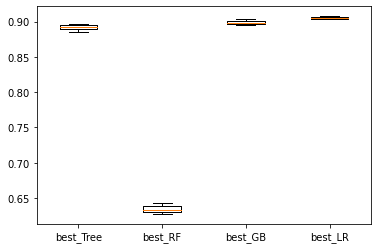

In [102]:
plt.boxplot(x=[cross_val_score2, cross_val_score3, cross_val_score4, cross_val_score5], labels=['best_Tree', 'best_RF', 'best_GB', 'best_LR'])

In [ ]:
В среднем мы получаем больше качество с помощью градиентного бустинга, но при этом он работает дольше всех